In [1]:

import pandas as pd
df = pd.read_csv('somall.csv', encoding = 'unicode_escape')
#full_text is fine

df_copy = df
print(len(df_copy))
serlis=df_copy.duplicated().tolist()
print(serlis.count(True)) #7479

serlis=df_copy.duplicated(['full_text']).tolist()
print(serlis.count(True))

14195
112
8585


In [5]:
import pandas as pd
import re
import time
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag,map_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

pstem = PorterStemmer()
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def clean_df(df_copy):
    
    #DROPS
    #CHOOSE EITHER TO DROP ALL-ROW DUPLICATES OR FULL_TEXT DUPLICATES
    df_copy=df_copy.drop_duplicates(['full_text']) #3377 left after this
    df_copy=df_copy.reset_index(drop=True)
    df_copy=df_copy.drop(['place','coordinates','geo','id_str'],axis=1)
    #df_copy=
    
    # BASIC CLEANING FUNCTION
    for i in range(len(df_copy)):
        txt = df_copy.loc[i]["full_text"]
        txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#username-tags
        txt=re.sub(r'^[RT]+','',txt)#RT-tags
        txt = re.sub('https?://[A-Za-z0-9./]+','',txt)#URLs
        txt=re.sub("[^a-zA-Z]", " ",txt)#hashtags
        df_copy.at[i,"full_text"]=txt
    #POS-TAGGING AND SENTIMENT SCORE
    li_swn=[]
    li_swn_pos=[]
    li_swn_neg=[]
    missing_words=[]
    for i in range(len(df_copy.index)):
        text = df_copy.loc[i]['full_text']
        tokens = nltk.word_tokenize(text)
        tagged_sent = pos_tag(tokens)
        store_it = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in tagged_sent]
        #print("Tagged Parts of Speech:",store_it)

        pos_total=0
        neg_total=0
        for word,tag in store_it:
            if(tag=='NOUN'):
                tag='n'
            elif(tag=='VERB'):
                tag='v'
            elif(tag=='ADJ'):
                tag='a'
            elif(tag=='ADV'):
                tag = 'r'
            else:
                tag='nothing'

            if(tag!='nothing'):   
                concat = word+'.'+tag+'.01'
                try:
                    this_word_pos=swn.senti_synset(concat).pos_score()
                    this_word_neg=swn.senti_synset(concat).neg_score()
                    #print(word,tag,':',this_word_pos,this_word_neg)
                except Exception as e:
                    wor = lem.lemmatize(word)
                    concat = wor+'.'+tag+'.01'
                    # Checking if there's a possiblity of lemmatized word be accepted into SWN corpus
                    try:
                        this_word_pos=swn.senti_synset(concat).pos_score()
                        this_word_neg=swn.senti_synset(concat).neg_score()
                    except Exception as e:
                        wor = pstem.stem(word)
                        concat = wor+'.'+tag+'.01'
                        # Checking if there's a possiblity of lemmatized word be accepted
                        try:
                            this_word_pos=swn.senti_synset(concat).pos_score()
                            this_word_neg=swn.senti_synset(concat).neg_score()
                        except:
                            missing_words.append(word) 
                            continue
                pos_total+=this_word_pos
                neg_total+=this_word_neg
        li_swn_pos.append(pos_total)
        li_swn_neg.append(neg_total)

        if(pos_total!=0 or neg_total!=0):
            if(pos_total>neg_total):
                li_swn.append(1)
            else:
                li_swn.append(-1)
        else:
            li_swn.append(0)
    # end-of pos-tagging&sentiment
    
    #3-rd for loop    
    #LEMMATIZING,STEMMING,STOP-WORDS
    for i in range(len(df_copy.index)):
        text = df_copy.loc[i]['full_text']
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]

        for j in range(len(tokens)):
            tokens[j] = lem.lemmatize(tokens[j])
            tokens[j] = pstem.stem(tokens[j])

        tokens_sent=' '.join(tokens)
        df_copy.at[i,"full_text"] = tokens_sent
        
    df_copy.insert(5,"pos_score",li_swn_pos,True)
    df_copy.insert(6,"neg_score",li_swn_neg,True)
    df_copy.insert(7,"sent_score",li_swn,True)
    
    
    
    return df_copy

st=time.time()
df_copy = clean_df(df_copy)
end=time.time()

# df_copy.loc[4]
print(end-st)#
# df_copy
# takes(no senti) 0.7440352439880371 with txt less..so go with it
# takes(no senti) 3.600219488143921 with df_copy.loc

25.341181755065918


In [7]:
df_copy

,full_text,retweet_count,user_followers_count,favorite_count,created_at,pos_score,neg_score,sent_score
0,distribut water purif kit packet drink water m...,4,5,0,Tue Jul 16 11:03:02 +0000 2019,0.250,0.000,1
1,A door door wast segreg awar drive carri membe...,1,126,0,Tue Jul 16 11:01:34 +0000 2019,0.625,0.000,1
2,A door door wast segreg awar drive carri membe...,1,165658,5,Tue Jul 16 11:00:01 +0000 2019,0.625,0.000,1
3,indianoil along conduct swachhta drive sabarma...,5,108,0,Tue Jul 16 10:58:13 +0000 2019,0.000,0.000,0
4,social scienc depart N S S eco club legal lite...,0,1618,1,Tue Jul 16 10:52:34 +0000 2019,0.250,0.000,1
5,pleas retweet let stoplitt cleandelhi swachhbh...,7,43,0,Tue Jul 16 10:50:33 +0000 2019,0.000,0.000,0
6,lead citi swachhata leagu take pledg keep surr...,4,11851,0,Tue Jul 16 10:41:31 +0000 2019,0.625,0.375,1
7,bhubaneswar municip corpor carri cleanli drive...,4,11851,0,Tue Jul 16 10:41:19 +0000 2019,0.375,0.000,1
8,bpcl organis cleanli amp awar drive manjeri bu...,5,11851,0,Tue Jul 16 10:41:01 +0000 2019,0.875,0.000,1
9,indian oil organis variou swacchata activ like...,4,11851,0,Tue Jul 16 10:40:50 +0000 2019,1.750,0.500,1


In [1]:
df_copy.to_csv('useit_all.csv',index=False)

NameError: name 'df_copy' is not defined

In [2]:
import pandas as pd
df_copy = pd.read_csv('useit_all.csv',index_col=False)

## DV
### WordCloud

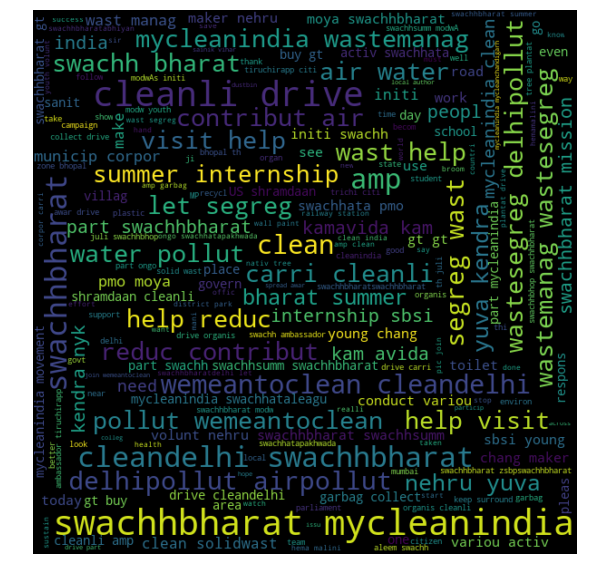

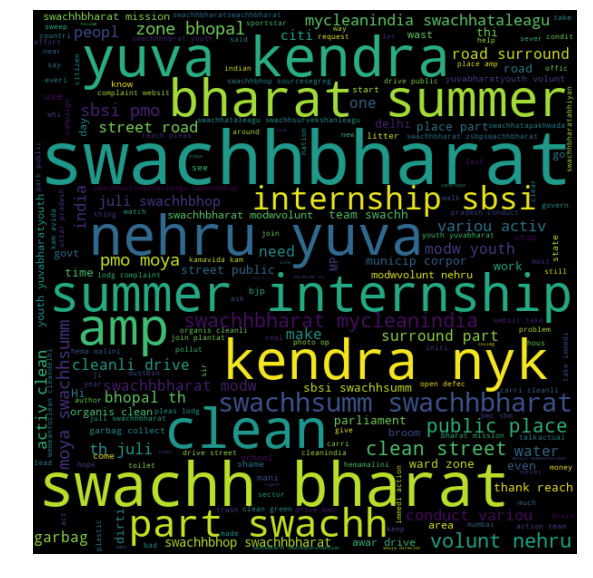

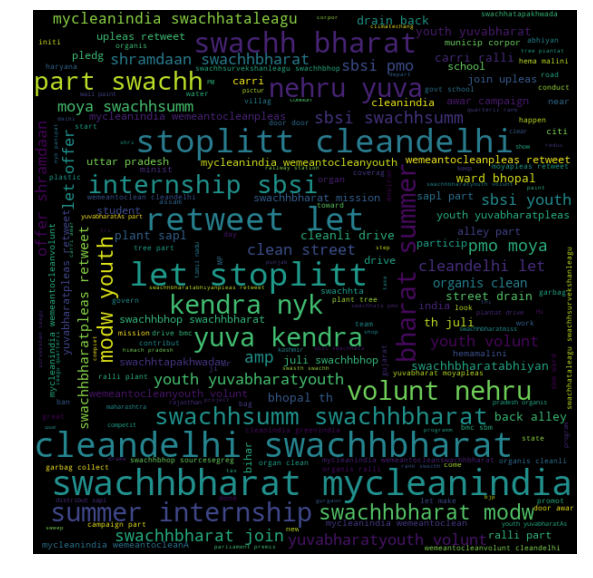

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# GENERATE POSITIVE TEXT,NEGATIVE TEXT,NEUTRAL TEXT FOR DATA-VISUALISATION
pos_text=""
neg_text=""
neut_text=""

for i in range(len(df_copy.index)):
    if(df_copy.loc[i]["sent_score"]==1):
        pos_text+=df_copy.loc[i]["full_text"]
    elif(df_copy.loc[i]["sent_score"]==-1):
        neg_text+=df_copy.loc[i]["full_text"]
    else:
        neut_text+=df_copy.loc[i]["full_text"]

list_text = [pos_text,neg_text,neut_text]


for txt in list_text:
    word_cloud = WordCloud(width = 600,height = 600,max_font_size = 200).generate(txt)
    plt.figure(figsize=(12,10))# create a new figure
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()



## split the data

In [3]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
SEED =4

x = df_copy.full_text
y = df_copy.sent_score

x_train,x_val_test,y_train,y_val_test = train_test_split(x,y,test_size=0.1,random_state=SEED)
x_val,x_test,y_val,y_test = train_test_split(x_val_test,y_val_test,test_size=0.5,random_state=SEED)

x_train_copy = x_train
y_train_copy = y_train
x_val_copy = x_val
y_val_copy = y_val
# print(len(x_train),len(x_test),len(x_val))

## CV&Tf - ALL

In [4]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import cross_validate,KFold
import datetime
import time
import pandas as pd
#a list of classes
classifiers = [MultinomialNB(),BernoulliNB(),LogisticRegression(),LinearSVC(),AdaBoostClassifier(),RidgeClassifier(),PassiveAggressiveClassifier(),Perceptron(),RandomForestClassifier()]
clf_names = ['MultinomialNB()','BernoulliNB()','LogisticRegression()','LinearSVC()','AdaBoostClassifier()','RidgeClassifier()','PassiveAggressiveClassifier()','Perceptron()','RandomForest Classifier']
data=[]

for v in ['cv','tf']:

    for gram in range(1,4):
        i=0

        for clf in classifiers:
            
            if(clf=='RandomForest Classifier'):#special case
                clf = RandomForestClassifier(random_state=0,n_jobs=-1,class_weight="balanced")

            before = datetime.datetime.now()
            before = before.strftime("%H:%M:%S")
            start = time.time()
            
            if(v=='cv'):
                vec = TfidfVectorizer(ngram_range=(1,gram))
            else:
                vec = CountVectorizer(ngram_range=(1,gram))
                
            model = make_pipeline(vec,clf)
            model.fit(x_train_copy.values.astype('U'),y_train_copy.values.astype('U'))##
            labels = model.predict(x_val_copy.values.astype('U'))
            ac = accuracy_score(y_val_copy.values.astype('U'),labels)
            kfold = KFold(n_splits=10,shuffle=False,random_state=None)
            results = cross_validate(model,x_train_copy.values.astype('U'),y_train_copy.values.astype('U'),cv=kfold)
            crossval_test_score_mean=results['test_score'].mean()
            crossval_train_score_mean=results['train_score'].mean()
            crossval_test_score_std=results['test_score'].std()
            crossval_train_score_std=results['train_score'].std()
            after = datetime.datetime.now()
            after = after.strftime("%H:%M:%S")
            end = time.time()
            hours = int(after[0:2])-int(before[0:2])
            mins = int(after[3:5])-int(before[3:5])
            secs = int(after[6:8])-int(before[6:8])
            time_taken = str(hours)+":"+str(mins)+":"+str(secs)
            gr = str(gram)
            vec_gram = v+"_"+gr
            data.append([vec_gram,clf_names[i],ac,crossval_train_score_mean,crossval_test_score_mean,crossval_train_score_std,crossval_test_score_std, end-start])
            i+=1
#     data.append([0,0,0,0,0,0,0,0])
d = pd.DataFrame(data,columns=['Vec_Gram','Classifier','Ac','crossval_train_score_mean','crossval_test_score_mean','crossval_train_score_std','crossval_test_score_std','Time.2'])
        
#         d['Ac_rank'] = d['Ac'].rank(ascending=False)
#         d['Time_rank'] = d['Time.2'].rank(ascending=False)
#         d['C-rank'] = d['Ac_rank'] + d['Time_rank']
#         d['C-rank'] = d['C-rank'].rank(ascending=False)

# print(d)
        
fname = "all_clfs.csv"
d.to_csv(fname)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class opt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [18]:
# cf = pd.read_csv('all_clfs.csv',index_col=False)
# cf.to_csv('all_clfs.csv',index=False)

In [5]:
d

,Vec_Gram,Classifier,Ac,crossval_train_score_mean,crossval_test_score_mean,crossval_train_score_std,crossval_test_score_std,Time.2
0,cv_1,MultinomialNB(),0.667857,0.793424,0.710449,0.001954,0.026873,2.067595
1,cv_1,BernoulliNB(),0.732143,0.840034,0.740549,0.002353,0.024560,1.891118
2,cv_1,LogisticRegression(),0.750000,0.848705,0.756197,0.001783,0.020643,2.860167
3,cv_1,LinearSVC(),0.803571,0.988755,0.810856,0.000855,0.018430,2.449579
4,cv_1,AdaBoostClassifier(),0.621429,0.710438,0.691629,0.008122,0.018342,8.002361
5,cv_1,RidgeClassifier(),0.778571,0.967386,0.804321,0.001285,0.023230,3.611852
6,cv_1,PassiveAggressiveClassifier(),0.807143,0.994322,0.810657,0.000953,0.013122,2.357725
7,cv_1,Perceptron(),0.810714,0.985850,0.805509,0.002582,0.014426,2.194157
8,cv_1,RandomForest Classifier,0.728571,0.991549,0.775008,0.000813,0.018861,4.950768
9,cv_2,MultinomialNB(),0.660714,0.834181,0.707873,0.002342,0.022856,4.378786


## GENSIM-MODELS

In [9]:
from tqdm import tqdm
import numpy as np
import pandas as pd
tqdm.pandas(desc='progress-bar')
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

# LABEL TWEETS-FOR ALL MODELS
#function-to-label
def label_tweets(tweets,label):
    result = []
    prefix = label
    i=0
    for i, t in zip(tweets.index, tweets):
        t=str(t)
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

#better-results-when-we build the vocabulary with alll the dataset,instead of just training set
x_all = pd.concat([x_train,x_val,x_test])

#label-function-call
x_all_w2v = label_tweets(x_all,'d2v')

#FUNCTION TO GET D2V-VECTORS FOR TRAINING AND VALIDATION DATASET-USED LATER IN EACH MODEL

def get_d2v_vectors(model,corpus,size):
    vecs = np.zeros((len(corpus),size))
    n=0
    for i in corpus.index:
        prefix='d2v_'+str(i)
        vecs[n] = model.docvecs[prefix]
        n+=1
    return vecs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).


## DBOW

In [10]:
cpu_count = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0,size=100,negative=5,min_count=2,alpha=0.065,workers=cpu_count,min_alpha=0.065)
model_dbow.build_vocab([each for each in tqdm(x_all_w2v)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([each for each in tqdm(x_all_w2v)]),total_examples=len(x_all_w2v),epochs=1)
    model_dbow.alpha-=0.002
    model_dbow.min_alpha = model_dbow.alpha

train_vecs_dbow = get_d2v_vectors(model_dbow,x_train,100)
val_vecs_dbow = get_d2v_vectors(model_dbow,x_val,100)


100%|██████████████████████████████████████████████████████████████████████████████████████| 5610/5610 [00:00<?, ?it/s]


## DMC

In [11]:
cpu_count = multiprocessing.cpu_count()
model_dmc = Doc2Vec(dm=1,dm_concat=1,size=100,negative=5,min_count=2,alpha=0.065,workers=cpu_count,min_alpha=0.065)
model_dmc.build_vocab([each for each in tqdm(x_all_w2v)])

for epoch in range(30):
    model_dmc.train(utils.shuffle([each for each in tqdm(x_all_w2v)]),total_examples=len(x_all_w2v),epochs=1)
    model_dmc.alpha-=0.002
    model_dmc.min_alpha = model_dmc.alpha


train_vecs_dmc = get_d2v_vectors(model_dmc,x_train,100)
val_vecs_dmc = get_d2v_vectors(model_dmc,x_val,100)

100%|██████████████████████████████████████████████████████████████████████████████████████| 5610/5610 [00:00<?, ?it/s]


## DMM

In [12]:
cpu_count = multiprocessing.cpu_count()
model_dmm = Doc2Vec(dm=1,dm_mean=1,size=100,negative=5,min_count=2,alpha=0.065,workers=cpu_count,min_alpha=0.065)
model_dmm.build_vocab([each for each in tqdm(x_all_w2v)])

for epoch in range(30):
    model_dmm.train(utils.shuffle([each for each in tqdm(x_all_w2v)]),total_examples=len(x_all_w2v),epochs=1)
    model_dmm.alpha-=0.002
    model_dmm.min_alpha = model_dmm.alpha

train_vecs_dmm = get_d2v_vectors(model_dmm,x_train,100)
val_vecs_dmm = get_d2v_vectors(model_dmm,x_val,100)



100%|██████████████████████████████████████████████████████████████████████████████████████| 5610/5610 [00:00<?, ?it/s]


In [13]:
#FUNCTION TO CONCAT 2-MODELS VECTORS..NO SPECIAL TRAINING IS REQUIRED
def get_concat_vectors(model1,model2,corpus,size):
    vecs = np.zeros((len(corpus),size))
    n=0
    for i in corpus.index:
        prefix='d2v_'+str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n+=1
    return vecs

## DBOW+DMM

In [14]:
train_vecs_dbow_dmm = get_concat_vectors(model_dbow,model_dmm,x_train,200)
val_vecs_dbow_dmm = get_concat_vectors(model_dbow,model_dmm,x_val,200)

## DBOW+DMC

In [15]:
train_vecs_dbow_dmc = get_concat_vectors(model_dbow,model_dmc,x_train,200)
val_vecs_dbow_dmc = get_concat_vectors(model_dbow,model_dmc,x_val,200)

In [16]:
#SAVING ALL MODELS FOR ANY FUTURE USE
model_dbow.save('d2v_model_dbow.doc2vec')
model_dmm.save('d2v_model_dmm.doc2vec')
model_dmc.save('d2v_model_dmc.doc2vec')
#AFTER THE FIRST TIME DON'T RETRAIN ALL THE MODELS,JUST LOAD THESE

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## all models-classifiers


In [17]:
vecs = [(train_vecs_dbow,val_vecs_dbow),(train_vecs_dmc,val_vecs_dmc),(train_vecs_dmm,val_vecs_dmm),(train_vecs_dbow_dmm,val_vecs_dbow_dmm),(train_vecs_dbow_dmc,val_vecs_dbow_dmc)]

In [20]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
import datetime
import time
import pandas as pd

classifiers = [BernoulliNB(),LogisticRegression(),LinearSVC(),AdaBoostClassifier(),RidgeClassifier(),PassiveAggressiveClassifier(),Perceptron()]
clf_names = ['BernoulliNB()','LogisticRegression()','LinearSVC()','AdaBoostClassifier()','RidgeClassifier()','PassiveAggressiveClassifier()','Perceptron()']
gensim_names = ['DBOW','DMC','DMM','DBOW+DMM','DBOW+DMC']
data=[]
j=0
for train_vecs,val_vecs in vecs:
    i=0
    for clf in classifiers:

        before = datetime.datetime.now()
        before = before.strftime("%H:%M:%S")
        start = time.time()


        clf.fit(train_vecs,y_train)
        ac = clf.score(val_vecs,y_val)

        after = datetime.datetime.now()
        after = after.strftime("%H:%M:%S")
        end = time.time()
        hours = int(after[0:2])-int(before[0:2])
        mins = int(after[3:5])-int(before[3:5])
        secs = int(after[6:8])-int(before[6:8])
        time_taken = str(hours)+":"+str(mins)+":"+str(secs)
        data.append([gensim_names[j],clf_names[i],ac,end-start])
        i+=1
    j+=1
d = pd.DataFrame(data,columns=['Model','Classifier','Ac','Time'])
#     d['Ac_rank'] = d['Ac'].rank(ascending=False)
#     d['Time_rank'] = d['Time.2'].rank(ascending=False)
#     d['C-rank'] = d['Ac_rank'] + d['Time_rank']
#     d['C-rank'] = d['C-rank'].rank(ascending=False)

print(d)
d.to_csv('gensim_all_clfs.csv')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added i

       Model                     Classifier        Ac      Time
0       DBOW                  BernoulliNB()  0.557143  0.043998
1       DBOW           LogisticRegression()  0.653571  0.528057
2       DBOW                    LinearSVC()  0.653571  2.284000
3       DBOW           AdaBoostClassifier()  0.617857  3.091993
4       DBOW              RidgeClassifier()  0.642857  0.007953
5       DBOW  PassiveAggressiveClassifier()  0.578571  0.047993
6       DBOW                   Perceptron()  0.525000  0.036004
7        DMC                  BernoulliNB()  0.510714  0.015996
8        DMC           LogisticRegression()  0.514286  0.107998
9        DMC                    LinearSVC()  0.514286  0.228004
10       DMC           AdaBoostClassifier()  0.500000  3.167995
11       DMC              RidgeClassifier()  0.514286  0.011999
12       DMC  PassiveAggressiveClassifier()  0.514286  0.044003
13       DMC                   Perceptron()  0.414286  0.031997
14       DMM                  BernoulliN